# 04/06/2023 Update



1. Started bringing in the main Census fields we need (still need to bring in more but that will be easy enough)
2. Performed the tribal land in each state analysis


### Tribal Area in Each State

Text(0.5, 1.0, 'Map of the United States and Tribal Land')

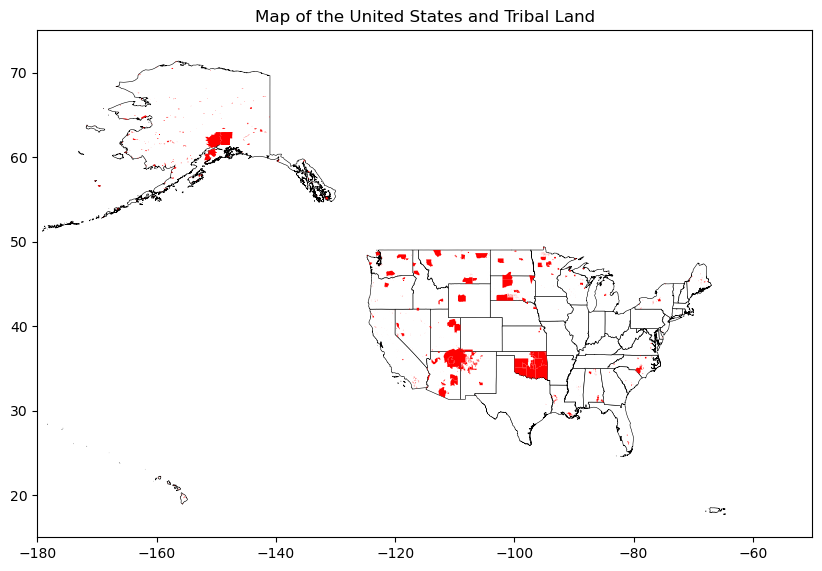

In [8]:
'''
Tribal Land Calculation


For this section, we want to grab the shapefile for tribal orgs in the US
and US State shapefiles. From there, we'll find where they overlap and what 
percent of each state is tribal
'''

import geopandas as gpd
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#Tribal Organizations Shapefile
tribal_maps = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2020/AIANNH/tl_2020_us_aiannh.zip')
#State map shapefiles
state_maps = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip')


#Do a quick plot to see what we're dealing with here
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
state_maps.plot(ax=ax, color='white', edgecolor='black', linewidth= .4)
tribal_maps.plot(ax=ax, color='red')
plt.xlim([-180, -50])
plt.ylim([15, 75])
plt.title("Map of the United States and Tribal Land")

In [7]:
#Get the overlay of our state map and tribal shapefiles
merged = gpd.overlay(state_maps, tribal_maps, how='intersection')

#Sum up our tribal land by state
state_land = merged.dissolve(by='STATEFP')

#Grab the area of tribal land within each state
indian_area = (state_land.area).reset_index(drop=False)
indian_area.columns = ['STATEFP', 'indian_area']

#Grab the total area in a state
state_area = state_maps.dissolve(by='STATEFP').area.reset_index(drop=False)
state_area.columns = ['STATEFP', 'state_area']

#Join our dataframes together
area_df = pd.merge(indian_area, state_area,
                   how='outer',
                   on= 'STATEFP')

#Create our percent calculation
area_df['Percent_Tribal_Land'] = area_df['indian_area'] / area_df['state_area']
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(area_df.head())

  STATEFP  indian_area  state_area  Percent_Tribal_Land
0      01        0.405      12.892                0.031
1      02        9.335     282.011                0.033
2      04        8.189      28.919                0.283
3      05        0.000      13.585                0.000
4      06        0.274      41.668                0.007


## American Community Survey API

We briefly touched on this last time, but here's the updated pull based on:

1. The geographic area being state
2. For right now, only grabbing demographic columns that appear in the FNS reports

In [9]:
import pandas as pd

#This is the list of all the columns we're going to grab
code_map = ["Estimate!!Total:",
"Estimate!!Total:!!Male:",
"Estimate!!Total:!!Male:!!Under 5 years	",
"Estimate!!Total:!!Male:!!5 to 9 years",
"Estimate!!Total:!!Male:!!10 to 14 years",
"Estimate!!Total:!!Male:!!15 to 17 years",	
"Estimate!!Total:!!Male:!!18 and 19 years",
"Estimate!!Total:!!Male:!!20 years",
"Estimate!!Total:!!Male:!!21 years",
"Estimate!!Total:!!Male:!!22 to 24 years",
"Estimate!!Total:!!Male:!!25 to 29 years",
"Estimate!!Total:!!Male:!!30 to 34 years",
"Estimate!!Total:!!Male:!!35 to 39 years",
"Estimate!!Total:!!Male:!!40 to 44 years",
"Estimate!!Total:!!Male:!!45 to 49 years",
"Estimate!!Total:!!Male:!!50 to 54 years",
"Estimate!!Total:!!Male:!!55 to 59 years",
"Estimate!!Total:!!Male:!!60 and 61 years",
"Estimate!!Total:!!Male:!!62 to 64 years",
"Estimate!!Total:!!Male:!!65 and 66 years",
"Estimate!!Total:!!Male:!!67 to 69 years",
"Estimate!!Total:!!Male:!!70 to 74 years",
"Estimate!!Total:!!Male:!!75 to 79 years",
"Estimate!!Total:!!Male:!!80 to 84 years",
"Estimate!!Total:!!Male:!!85 years and over",
"Estimate!!Total:!!Female:",
"Estimate!!Total:!!Female:!!Under 5 years	",
"Estimate!!Total:!!Female:!!5 to 9 years",
"Estimate!!Total:!!Female:!!10 to 14 years",
"Estimate!!Total:!!Female:!!15 to 17 years",	
"Estimate!!Total:!!Female:!!18 and 19 years",
"Estimate!!Total:!!Female:!!20 years",
"Estimate!!Total:!!Female:!!21 years",
"Estimate!!Total:!!Female:!!22 to 24 years",
"Estimate!!Total:!!Female:!!25 to 29 years",
"Estimate!!Total:!!Female:!!30 to 34 years",
"Estimate!!Total:!!Female:!!35 to 39 years",
"Estimate!!Total:!!Female:!!40 to 44 years",
"Estimate!!Total:!!Female:!!45 to 49 years",
"Estimate!!Total:!!Female:!!50 to 54 years",
"Estimate!!Total:!!Female:!!55 to 59 years",
"Estimate!!Total:!!Female:!!60 and 61 years",
"Estimate!!Total:!!Female:!!62 to 64 years",
"Estimate!!Total:!!Female:!!65 and 66 years",
"Estimate!!Total:!!Female:!!67 to 69 years",
"Estimate!!Total:!!Female:!!70 to 74 years",
"Estimate!!Total:!!Female:!!75 to 79 years",
"Estimate!!Total:!!Female:!!80 to 84 years",
"Estimate!!Total:!!Female:!!85 years and over",
"Estimate!!Total:",
"Estimate!!Total:!!White alone",
"Estimate!!Total:!!Black or African American alone",
"Estimate!!Total:!!American Indian and Alaska Native alone",
"Estimate!!Total:!!Asian alone",
"Estimate!!Total:!!Native Hawaiian and Other Pacific Islander alone",
"Estimate!!Total:!!Some other race alone",
"Estimate!!Total:!!Two or more races:",
"Estimate!!Total:!!Two or more races:!!Two races including Some other race",
"Estimate!!Total:!!Two or more races:!!Two races excluding Some other race, and three or more races"]

#These are the actual codes for the columns we're going to grab
code_list = [
    'B01001_001E',
    'B01001_002E',
    'B01001_003E',
    'B01001_004E',
    'B01001_005E',
    'B01001_006E',
    'B01001_007E',
    'B01001_008E',
    'B01001_009E',
    'B01001_010E',
    'B01001_011E',
    'B01001_012E',
    'B01001_013E',
    'B01001_014E',
    'B01001_015E',
    'B01001_016E',
    'B01001_017E',
    'B01001_018E',
    'B01001_019E',
    'B01001_020E',
    'B01001_021E',
    'B01001_022E',
    'B01001_023E',
    'B01001_024E',
    'B01001_025E',
    'B01001_026E',
    'B01001_027E',
    'B01001_028E',
    'B01001_029E',
    'B01001_030E',
    'B01001_031E',
    'B01001_032E',
    'B01001_033E',
    'B01001_034E',
    'B01001_035E',
    'B01001_036E',
    'B01001_037E',
    'B01001_038E',
    'B01001_039E',
    'B01001_040E',
    'B01001_041E',
    'B01001_042E',
    'B01001_043E',
    'B01001_044E',
    'B01001_045E',
    'B01001_046E',
    'B01001_047E',
    'B01001_048E',
    'B01001_049E',
    'B02001_001E',
    'B02001_002E',
    'B02001_003E',
    'B02001_004E',
    'B02001_005E',
    'B02001_006E',
    'B02001_007E',
    'B02001_008E',
    'B02001_009E',
    'B02001_010E']

#Now we store it in a dictionary
my_dict = dict(zip(code_map,code_list))

#The free version of the API only lets you request 50 columns at a time, so we chunk up our columns
first_pull = code_list[:45]
second_pull = code_list[45:]

#Pulling down the data
first_pull = pd.read_json(f"https://api.census.gov/data/2021/acs/acs5?get=NAME,{','.join(first_pull)}&for=state:*")
second_pull = pd.read_json(f"https://api.census.gov/data/2021/acs/acs5?get=NAME,{','.join(second_pull)}&for=state:*")


#Clean up the json column name formatting
first_pull.columns = first_pull.iloc[0]
first_pull = first_pull.drop(0, axis=0)

second_pull.columns = second_pull.iloc[0]
second_pull = second_pull.drop(0, axis=0)

#Do an inner join so we don't have duplicate state columns
api_df = pd.merge(first_pull, second_pull,
                  how = 'inner',
                  on = ['NAME','state'])

print(api_df.head())

0        NAME B01001_001E B01001_002E B01001_003E B01001_004E B01001_005E  \
0     Alabama     4997675     2429703      151356      155081      167636   
1      Alaska      735951      384749       25965       27379       25485   
2     Arizona     7079203     3533895      210607      224911      244849   
3    Arkansas     3006309     1483520       95410       99723      105077   
4  California    39455353    19714044     1203859     1245934     1362100   

0 B01001_006E B01001_007E B01001_008E B01001_009E  ... B02001_001E  \
0       99974       67361       36835       33355  ...     4997675   
1       14977        9878        5752        6367  ...      735951   
2      144036       99223       51285       49589  ...     7079203   
3       62435       41759       23469       20434  ...     3006309   
4      792617      529966      279345      269923  ...    39455353   

0 B02001_002E B02001_003E B02001_004E B02001_005E B02001_006E B02001_007E  \
0     3338590     1324233       21661  